<a href="https://colab.research.google.com/github/duongn169/duongn169/blob/main/Final_ProjectAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

import os
import random
from keras.preprocessing.image import ImageDataGenerator

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)

################ Parameters #####################
path = "/content/drive/MyDrive/data/Koi Fish"  # folder chứa 18 folder của các classes
testRatio = 0.2  # Chia 20% số ảnh cho testing
validationRatio = 0.2  # Còn lại 80% cho train => Chia 20% cho validation

In [5]:
# Import Ảnh
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Tổng số Classes: ", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Tổng số Classes:  18
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17  


In [6]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [7]:
# Kiểm tra số lượng ảnh có bằng với số LABLES cho mỗi dataset
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[0]), " TRAINING SET: Số lượng ảnh khác số lượng lables!"
assert (X_validation.shape[0] == y_validation.shape[0]), " VALIDATION SET: Số lượng ảnh khác số lượng lables!"
assert (X_test.shape[0] == y_test.shape[0]), " TESTING SET: Số lượng ảnh khác số lượng lables!"
assert (X_train.shape[1:] == (32,32,3)), " Kích thước ảnh Training SAI! "
assert (X_validation.shape[1:] == (32,32,3)), " Kích thước ảnh Validation SAI! "
assert (X_test.shape[1:] == (32,32,3)), " Kích thước ảnh Test SAI!"

Data Shapes
Train(544, 32, 32, 3) (544,)
Validation(136, 32, 32, 3) (136,)
Test(170, 32, 32, 3) (170,)


In [8]:
# READ CSV FILE
data = pd.read_csv('/content/drive/MyDrive/data/fish.csv') # File chứa tên và ID các classes
print("data shape ", data.shape, type(data))

data shape  (18, 2) <class 'pandas.core.frame.DataFrame'>


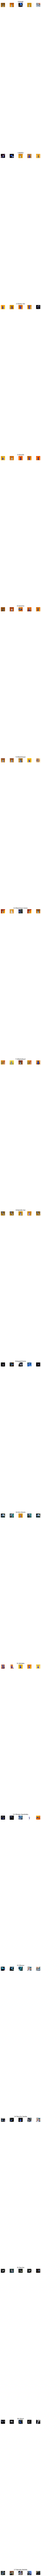

In [9]:
# Biểu diễn ngẫu nhiên một số ảnh mẫu
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))


[37, 20, 15, 28, 24, 18, 21, 7, 10, 35, 21, 44, 33, 33, 50, 42, 51, 55]


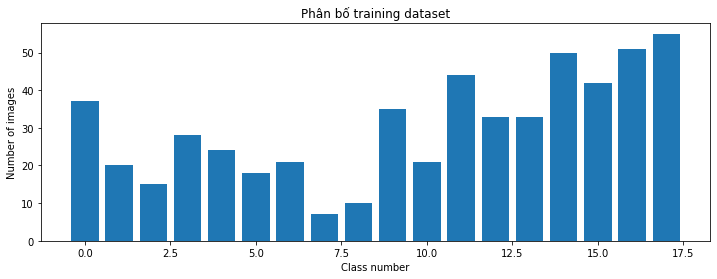

In [10]:
# PLOT biểu đồ cột về số lượng Samples cho mỗi loại
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Phân bố training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [11]:
# Xử lý ảnh
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)  # Cân bằng sáng cho ảnh
    img = img / 255  # Scale ảnh về giá trị 0-1
    return img

In [12]:
# Lấy ảnh đã xử lý và đưa vào lại các tập
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [13]:
# Reshape về (32,32,1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [14]:
# Rotate, shift-L/R, zoom images
dataGen = ImageDataGenerator(width_shift_range=0.1,    # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

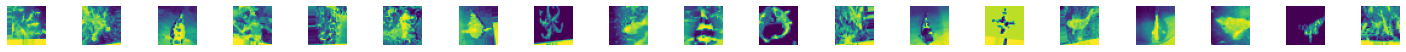

In [18]:
# Show ngẫu nhiên 19 ảnh sau xử lý
fig, axs = plt.subplots(1, 19, figsize=(20, 5))
fig.tight_layout()

for i in range(19):
    axs[i].imshow(X_batch[i].reshape((32, 32, 3)[0], (32, 32, 3)[1]))
    axs[i].axis('off')
plt.show()


In [19]:
# Chuyển thành one-hot
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [20]:
# CNN Model dựa theo LeNet
def myModel():
    num_Filters = 60
    size_of_Filter = (5, 5)  # KERNEL size.
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # Pooling size
    model = Sequential()
    model.add((Conv2D(num_Filters, size_of_Filter, input_shape=((32, 32, 3)[0], (32, 32, 3)[1], 1), activation='relu')))
    model.add((Conv2D(num_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))  # => Giảm Overfitting

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))  # HIDDEN LAYER
    model.add(Dropout(0.5))
    model.add(Dense(500, activation='relu'))  # HIDDEN LAYER
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
#Train model
model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train, y_train, batch_size=50),
                    epochs=2000, validation_data=(X_validation, y_validation), shuffle=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

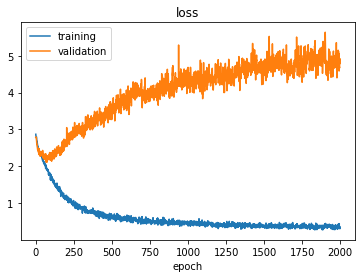

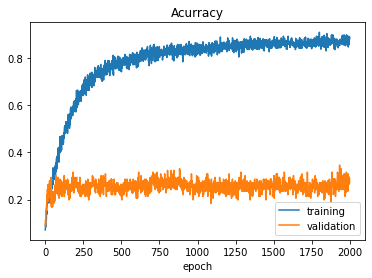

Test Score: 4.735355377197266
Test Accuracy: 0.25882354378700256


In [22]:
# PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [23]:
# Lưu model vào file .h5 để sử dụng cho real-time
model.save('/content/drive/MyDrive/data/model1.h5')